# Inference in Bayesian networks

We can implement exact inference using factors. Recall that factors represent discrete multivariate distributions. We use the following three operations on factors to achieve this:

#### 1. Factor product
We use the factor product to combine two factors to produce a larger factor whose scope is the combined scope of the input factors. If we have $φ(X, Y)$ and $ψ(Y, Z)$, then $φ · ψ$ will be over $X$, $Y$, and $Z$ with $(φ · ψ)(x, y, z) = φ(x, y)ψ(y, z)$. 

#### 2. Factor marginalization
We use factor marginalization to sum out a particular variable from the entire factor table, removing it from the resulting scope.

#### 3. Factor conditioning
We use factor conditioning with respect to some evidence to remove any rows in the table inconsistent with that evidence.

### Let's implement the code from last notebook (`1. Representations`) so we can reuse it

In [1]:
struct Variable
    name::Symbol
    m::Int
end

const Assignment = Dict{Symbol, Int}
const FactorTable = Dict{Assignment, Float64}

struct Factor
    vars::Vector{Variable}
    table::FactorTable
end

Base.Dict{Symbol, T}(a::NamedTuple) where T = 
    Dict{Symbol, T}( k=>v for (k,v) in zip(keys(a), values(a)) )

Base.convert(::Type{Dict{Symbol, T}}, a::NamedTuple) where T = 
    Dict{Symbol, T}(a)

Base.isequal(a::Dict{Symbol, T}, b::NamedTuple) where T = 
    length(a) == length(b) &&
    all(a[k] == v for (k,v) in zip(keys(b), values(b)))

variablenames(ϕ::Factor) = [var.name for var in ϕ.vars]

select(a::Assignment, varnames::Vector{Symbol}) = 
    Assignment( n => a[n] for n in varnames )

select (generic function with 1 method)

In [2]:
import Base.Iterators: product

function assignments(vars::AbstractVector{Variable})
    names = [var.name for var in vars]
    matrix_of_assignments = [Assignment(name => p for (name, p) in zip(names, p)) 
        for p in product((1:var.m for var in vars)...)]
    vec(matrix_of_assignments)
end

assignments (generic function with 1 method)

In [3]:
using LightGraphs

function normalize!(ϕ::Factor)
    if isempty(ϕ.table)
        return ϕ
    end
    z = sum(p for (a,p) in ϕ.table)
    for (a,p) in ϕ.table
        ϕ.table[a] = p/z
    end
    ϕ
end

struct BayesianNetwork
    vars::Vector{Variable}
    factors::Vector{Factor}
    graph::SimpleDiGraph{Int64}
end

In [4]:
# ?merge

### 1. Factor product

In [5]:
function Base.:*(ϕ::Factor, ψ::Factor)
    ϕ_names = variablenames(ϕ)
    ψ_names = variablenames(ψ)
    ψ_only = setdiff(ψ.vars, ϕ.vars)
    final_table = FactorTable()
    for (ϕ_assignment, ϕ_prob) in ϕ.table
        for ψ_only_assignment in assignments(ψ_only)
            complete_assignment = merge(ϕ_assignment, ψ_only_assignment)
            ψ_assignment = select(complete_assignment, ψ_names)
            final_table[complete_assignment] = ϕ_prob * get(ψ.table, ψ_assignment, 0.0)
        end
    end
    vars = vcat(ϕ.vars, ψ_only)
    Factor(vars, final_table)
end

### 2. Factor marginalization

In [6]:
function marginalize(ϕ::Factor, name::Symbol)
    final_table = FactorTable()
    for (assignment, prob) in ϕ.table
        assignment_without_name = delete!(copy(assignment), name)
        final_table[assignment_without_name] = get(final_table, assignment_without_name, 0.0) + prob
    end
    final_variables = filter(v -> v.name != name, ϕ.vars)
    Factor(final_variables, final_table)
end

marginalize (generic function with 1 method)

### 3. Factor conditioning

Two methods for factor conditioning given some evidence. 

i) The first takes a factor $φ$ and returns a new factor whose table entries are consistent with the variable named `name` having value `value`. 

ii) The second takes a factor $φ$ and applies evidence in the form of a named tuple. The `in_scope` method returns `true` if a variable named `name` is within the scope of the factor $φ$.

In [7]:
in_scope(name::Symbol, ϕ::Factor) = any(name == v.name for v in ϕ.vars)

function condition(ϕ::Factor, name::Symbol, value)
    if !in_scope(name, ϕ)
        return ϕ
    end
    final_table = FactorTable()
    for (assignment, prob) in ϕ.table
        if assignment[name] == value
            final_table[delete!(copy(assignment), name)] = prob
        end
    end
    final_variables = filter(v -> v.name != name, ϕ.vars)
    Factor(final_variables, final_table)
end

function condition(ϕ::Factor, evidence)
    for (name, value) in pairs(evidence)
        ϕ = condition(ϕ, name, value)
    end
    ϕ
end

condition (generic function with 2 methods)

In [8]:
# ?pairs

### Exact inference

A naive exact inference algorithm for a discrete Bayesian network `bn`, which takes as input a set of query variable names `query`, and `evidence` associating values with observed variables. 

The algorithm computes a joint distribution over the query variables in the form of a factor. 

> We introduce the `ExactInference` type to allow for `infer` to be called with different inference methods, as shall be seen in the rest of this chapter.

Notice how `ExactInference` parameter is not used in the function definition. It is solely used for multiple dispatch.

In [9]:
struct ExactInference end

In [10]:
function infer(::ExactInference, bn, query, evidence)
    ϕ = prod(bn.factors)
    ϕ = condition(ϕ, evidence)
    for name in setdiff(variablenames(ϕ), query)
        ϕ = marginalize(ϕ, name)
    end
    normalize!(ϕ)
end

infer (generic function with 1 method)

### Let's test on the example given in the book

In [11]:
X = Variable(:x, 2)
Y = Variable(:y, 2)
Z = Variable(:z, 2)

ϕ1 = Factor([X,Y], FactorTable(
        (x=1, y=1) => 0.3,
        (x=1, y=2) => 0.4,
        (x=2, y=1) => 0.2,
        (x=2, y=2) => 0.1,
        ))

ϕ2 = Factor([Y,Z], FactorTable(
        (y=1, z=1) => 0.2,
        (y=1, z=2) => 0.0,
        (y=2, z=1) => 0.3,
        (y=2, z=2) => 0.5,
        ));

#### Test factor product

In [12]:
result = ϕ1 * ϕ2
println(result.vars)
result.table

Variable[Variable(:x, 2), Variable(:y, 2), Variable(:z, 2)]


Dict{Dict{Symbol, Int64}, Float64} with 8 entries:
  Dict(:y=>1, :z=>1, :x=>1) => 0.06
  Dict(:y=>1, :z=>1, :x=>2) => 0.04
  Dict(:y=>1, :z=>2, :x=>1) => 0.0
  Dict(:y=>2, :z=>2, :x=>1) => 0.2
  Dict(:y=>2, :z=>1, :x=>2) => 0.03
  Dict(:y=>1, :z=>2, :x=>2) => 0.0
  Dict(:y=>2, :z=>2, :x=>2) => 0.05
  Dict(:y=>2, :z=>1, :x=>1) => 0.12

#### Test factor marginalization

In [13]:
X = Variable(:x, 2)
Y = Variable(:y, 2)
Z = Variable(:z, 2)

ϕ = Factor([X,Y,Z], FactorTable(
        (x=1, y=1, z=1) => 0.08,
        (x=1, y=1, z=2) => 0.31,
        (x=1, y=2, z=1) => 0.09,
        (x=1, y=2, z=2) => 0.37,
        (x=2, y=1, z=1) => 0.01,
        (x=2, y=1, z=2) => 0.05,
        (x=2, y=2, z=1) => 0.02,
        (x=2, y=2, z=2) => 0.07,
        ));

In [14]:
result = marginalize(ϕ, Y.name)
println(result.vars)
result.table

Variable[Variable(:x, 2), Variable(:z, 2)]


Dict{Dict{Symbol, Int64}, Float64} with 4 entries:
  Dict(:z=>2, :x=>2) => 0.12
  Dict(:z=>2, :x=>1) => 0.68
  Dict(:z=>1, :x=>1) => 0.17
  Dict(:z=>1, :x=>2) => 0.03

#### Test factor conditioning

In [15]:
result = condition(ϕ, :y, 2.0)
println(result.vars)
result.table

Variable[Variable(:x, 2), Variable(:z, 2)]


Dict{Dict{Symbol, Int64}, Float64} with 4 entries:
  Dict(:z=>2, :x=>2) => 0.07
  Dict(:z=>2, :x=>1) => 0.37
  Dict(:z=>1, :x=>1) => 0.09
  Dict(:z=>1, :x=>2) => 0.02

In [16]:
result = condition(ϕ, (y=2,x=1))
println(result.vars)
result.table

Variable[Variable(:z, 2)]


Dict{Dict{Symbol, Int64}, Float64} with 2 entries:
  Dict(:z=>1) => 0.09
  Dict(:z=>2) => 0.37

In [17]:
condition(ϕ, (g=2,x=1))

Factor(Variable[Variable(:y, 2), Variable(:z, 2)], Dict(Dict(:y => 2, :z => 2) => 0.37, Dict(:y => 1, :z => 1) => 0.08, Dict(:y => 1, :z => 2) => 0.31, Dict(:y => 2, :z => 1) => 0.09))

### Inference in Naive Bayes models

![](./assets/ex_3.3.png)

> We have to specify the prior $P(C)$ and the class-conditional distributions $P(O_i|C)$

> Our classification task involves computing the conditional probability $P(c | o_{1:n})$

$$P(c | o_{1:n}) = \frac{P(c, o_{1:n})}{P(o_{1:n})}$$

We can compute the denominator by marginalizing the joint distribution. The denominator is not a function of $C$ and can therefore be treated as a constant. Thus we can write

$$P(c | o_{1:n}) \propto P(c, o_{1:n})$$

### Sum-product variable elimination

Consider the below figure:

![](./assets/ex_2.5.png)

Let's say we want to compute the distribution $P(B | d^1, c^1)$

The conditional probability distributions associated with the nodes in the network can be __represented__ by the following factors:

$$ϕ_1(B), ϕ_2(S), ϕ_3(E,B,S), ϕ_4(D,E), ϕ_5(C,E)$$

Because $D$ and $C$ are observed variables, the last two factors can be replaced with $φ_6(E)$ and $φ_7(E)$ by setting the evidence $D = 1$ and $C = 1$.

We eliminate $E$ then $S$:

$$φ_8(B,S) = ∑_e φ_3(e,B,S)φ_6(e)φ_7(e)$$
$$φ_9(B) = ∑φ_2(s)φ_8(B,s)$$

Finally we take the product of $φ_9(B)$ and $φ_1(B)$ and normalize it to get $P(B|d^1,c^1)$

__Previous way__: Taking the product of all factors then marginalizing

$$ P(B | d^1,c^1) ∝ ∑_s ∑_e φ_1(B)φ_2(s)φ_3(e | B,s)φ_4(d^1 | e)φ_5(c^1 | e) $$


__Sum product way__:

$$ P(B | d^1, c^1) ∝ φ_1(B) ∑_s( φ_2(s) ∑_e (φ_3(e | B, s) φ_4(d^1 | e) φ_5(c^1 | e)) )$$

In [18]:
struct VariableElimination
    ordering # array of variable indices
end

function infer(M::VariableElimination, bn, query, evidence)
    ϕs_after_evidence = [condition(ϕ, evidence) for ϕ in bn.factors]
    for index in M.ordering
        name = bn.vars[index].name
        if name ∉ query
            indices_containing_name = findall(ϕ -> in_scope(name, ϕ), ϕs_after_evidence)
            if !isempty(indices_containing_name)
                ϕ = prod(ϕs_after_evidence[indices_containing_name])
                deleteat!(ϕs_after_evidence, indices_containing_name)
                ϕ_after_marginalizing = marginalize(ϕ, name)
                push!(ϕs_after_evidence, ϕ_after_marginalizing)
            end
        end
    end
    normalize!(prod(ϕs_after_evidence))
end
        

infer (generic function with 2 methods)

In [19]:
# ?deleteat!

In [20]:
# ?findall

### Let's test the new `infer` function

In [21]:
B = Variable(:b, 2)
S = Variable(:s, 2)
E = Variable(:e, 2)
D = Variable(:d, 2)
C = Variable(:c, 2)

vars = [B,S,E,D,C]

factorB = Factor([B], FactorTable((b=1,)=>0.99, (b=2,)=>0.01))
factorS = Factor([S], FactorTable((s=1,)=>0.98, (s=2,)=>0.02))
factorE = Factor([B,S,E], FactorTable(
        (e=1,b=1,s=1) => 0.90,
        (e=1,b=1,s=2) => 0.04,
        (e=1,b=2,s=1) => 0.05,
        (e=1,b=2,s=2) => 0.01,
        (e=2,b=1,s=1) => 0.10,
        (e=2,b=1,s=2) => 0.96,
        (e=2,b=2,s=1) => 0.95,
        (e=2,b=2,s=2) => 0.99,
        ))
factorD = Factor([D,E], FactorTable(
        (d=1,e=1) => 0.96,
        (d=1,e=2) => 0.03,
        (d=2,e=1) => 0.04,
        (d=2,e=2) => 0.97,
        ))
factorC = Factor([C,E], FactorTable(
        (c=1,e=1) => 0.98,
        (c=1,e=2) => 0.01,
        (c=2,e=1) => 0.02,
        (c=2,e=2) => 0.99,
        ))

graph = SimpleDiGraph(5)

add_edge!(graph, 1, 3)
add_edge!(graph, 2, 3)
add_edge!(graph, 3, 4)
add_edge!(graph, 3, 5)

bn = BayesianNetwork(vars, [factorB, factorS, factorE, factorD, factorC], graph);

In [22]:
M = VariableElimination([3,2]) # eliminate E then S
evidence = (d=2,c=2)
factor = infer(M, bn, [B.name], evidence)
println(factor.vars)
factor.table

Variable[Variable(:b, 2)]


Dict{Dict{Symbol, Int64}, Float64} with 2 entries:
  Dict(:b=>2) => 0.0753055
  Dict(:b=>1) => 0.924695

## Direct sampling

Idea: Random samples from the joint distribution are used to arrive at a probability estimate.

Suppose we want to infer $P(b^1 | d^1, c^1)$ from a set of `n` samples from the joint distribution `P(b,s,e,d,c)`. The direct sample estimate is:

$$ P(b^1 | d^1, c^1) ≈ \frac{\sum_i (b^{(i)} = 1 ∧ d^{(i)} = 1 ∧ c^{(i)} = 1)}{\sum_i (d^{(i)} = 1 ∧ c^{(i)} = 1)} $$

The first step involves finding a topological sort of the nodes in the Bayesian network. A topological sort always exists, but it may not be unique.

Once we have a topological sort, we can begin sampling from the conditional probability distributions.

In [23]:
function Base.rand(ϕ::Factor)
    # the idea is to return a random assignment from ϕ
    # the assignment is chosen based on the `random_number`
    # note that this will result in assignments with high probability being returned more often
    random_number = rand()
    total_prob = sum(values(ϕ.table))
    total = 0.0
    for (assignment, prob) in ϕ.table
        total += prob / total_prob
        if total >= random_number
            return assignment
        end
    end
    return Assignment()
end

In [24]:
bn.graph

{5, 4} directed simple Int64 graph

In [25]:
topological_sort_by_dfs(bn.graph)

5-element Vector{Int64}:
 2
 1
 3
 5
 4

#### Understand the below function in greater detail. Some points to note:

- `condition` function does not normalize the factors
- `rand` is applied to conditioned output

In [26]:
function Base.rand(bn::BayesianNetwork)
    output = Assignment()
    for i in topological_sort_by_dfs(bn.graph)
        variable, ϕ = bn.vars[i].name, bn.factors[i]
        random_assignment_from_factor = rand(condition(ϕ, output))
        output[variable] = random_assignment_from_factor[variable]
    end
    return output
end

In [27]:
struct DirectSampling
    m #number of samples
end

function infer(M::DirectSampling, bn, query, evidence)
    table = FactorTable()
    for i in 1:(M.m)
        assignment = rand(bn)
        if all(assignment[k] == v for (k,v) in pairs(evidence))
            sub_assignment = select(assignment, query)
            table[sub_assignment] = get(table, sub_assignment, 0) + 1
        end
    end
    vars = filter(v -> v.name ∈ query, bn.vars)
    return normalize!(Factor(vars, table))
end

infer (generic function with 3 methods)

Let's compare the empirical estimation with the actual values:

```julia
  Dict(:b=>2) => 0.0753055
  Dict(:b=>1) => 0.924695
```

In [28]:
infer(DirectSampling(100), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 1) => 1.0))

In [29]:
infer(DirectSampling(1000), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.05785123966942149, Dict(:b => 1) => 0.9421487603305785))

In [30]:
infer(DirectSampling(10000), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.0785296574770259, Dict(:b => 1) => 0.9214703425229741))

In [31]:
infer(DirectSampling(100000), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.07581816697951523, Dict(:b => 1) => 0.9241818330204847))

## Likelihood Weighted Sampling

Each sample `i` is given a weight $w_i$. This gives us:

$$ P(b^1 | d^1, c^1) ≈ \frac{\sum_i w_i(b^{(i)} = 1 ∧ d^{(i)} = 1 ∧ c^{(i)} = 1)}{\sum_i w_i(d^{(i)} = 1 ∧ c^{(i)} = 1)} $$

In this case we don't really sample all the variables. The evidence variables are set to their specified values. Eg in the graph above, `D` and `C` are not sampled. They are set equal to the evidence `d=1` and `c=1`. But `d=1` happens only `P(d=1|e)` fraction of the time. Similarly `c=1` happens only `P(c=1|e)` fraction of the time. Thus we multiply each sample with the weight `P(d=1|e) * P(d=c|e)` for the given value of `e` in the sample.

$$ = \frac{\sum_i w_i(b^{(i)} = 1)}{\sum_i w_i} $$

In [32]:
struct LikelihoodWeightedSampling
    m # number of samples
end

In [33]:
function infer(M::LikelihoodWeightedSampling, bn, query, evidence)
    table = FactorTable()
    ordering = topological_sort_by_dfs(bn.graph)
    for i in 1:M.m
        assignment, weight = Assignment(), 1.0
        for j in ordering
            variable_name, ϕ = bn.vars[j].name, bn.factors[j]
            if haskey(evidence, variable_name)
                assignment[variable_name] = evidence[variable_name]
                weight *= ϕ.table[select(assignment, variablenames(ϕ))]
            else
                assignment[variable_name] = rand(condition(ϕ,assignment))[variable_name]
            end
        end
        sub_assignment = select(assignment, query)
        table[sub_assignment] = get(table, sub_assignment, 0) + weight
    end
    vars = filter(v -> v.name ∈ query, bn.vars)
    return normalize!(Factor(vars, table))
end

infer (generic function with 4 methods)

In [34]:
infer(LikelihoodWeightedSampling(10), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 1) => 1.0))

In [35]:
infer(LikelihoodWeightedSampling(100), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 1) => 1.0))

In [36]:
infer(LikelihoodWeightedSampling(1000), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.0374033882730401, Dict(:b => 1) => 0.9625966117269599))

In [37]:
infer(LikelihoodWeightedSampling(10000), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.09088823398927763, Dict(:b => 1) => 0.9091117660107224))

In [38]:
infer(LikelihoodWeightedSampling(100000), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.07540498135116384, Dict(:b => 1) => 0.9245950186488362))

Although likelihood weighting makes it so that all samples are consistent with the observations, it can still be wasteful. Consider the simple chemical detection Bayesian network shown in figure below:

![](assets/fig_3.5.png)

One can easily see that $P(c^1 | d^1) = 0.5$. 

If we use likelihood weighting, then 99.9% of the samples will have `C = 0` with a weight of 0.001. Until we get a sample of `C = 1`, which has an associated weight of 0.999, our estimate of $P(c^1 | d^1)$ will be 0.

## Gibbs Sampling

Gibbs sampling involves drawing samples consistent with the evidence in a way that does not involve weighting. From these samples, we can infer the distribution over the query variables.

Using any ordering of the unobserved variables, assign to $X_i^{(k)}$ a value from the distribution presented by $P(X_i | x_{-i}^{(k)})$. Here $ x_{-i}^{(k)}$ represents the values of all other variables except $X_i$ in the `k-th` sample.

> Sampling from $P(X_i | x_{-i}^{(k)})$ can be done efficiently because we only need to consider the Markov blanket of $X_i$ 

In [39]:
function blanket(bn, assignment, index)
    # `assignment` is an assignment over all variables
    # ... in the bayesian network `bn`
    name = bn.vars[index].name
    assignment_without_variable = delete!(copy(assignment), name)
    factors_containing_name = filter(ϕ -> in_scope(name, ϕ), bn.factors)
    ϕ = prod(condition(ϕ, assignment_without_variable) for ϕ in factors_containing_name)
    return normalize!(ϕ)
end

function update_gibbs_sample!(assignment, bn, evidence, ordering)
    for index in ordering
        name = bn.vars[index].name
        if !haskey(evidence, name)
            assignment_of_name = blanket(bn, assignment, index)
            assignment[name] = rand(assignment_of_name)[name]
        end
    end
    return assignment
end
    
function gibbs_sample(assignment, bn, evidence, ordering, m)
    for j in 1:m
        assignment = update_gibbs_sample!(assignment, bn, evidence, ordering)
    end
    return assignment
end

struct GibbsSampling
    m_samples
    m_burn_in
    m_skip
    ordering
end

In [40]:
function infer(M::GibbsSampling, bn, query, evidence)
    table = FactorTable()
    assignment = merge(rand(bn), Assignment(evidence))
    assignment = gibbs_sample(assignment, bn, evidence, M.ordering, M.m_burn_in)
    for i in 1:(M.m_samples)
        assignment = gibbs_sample(assignment, bn, evidence, M.ordering, M.m_burn_in)
        sub_assignment = select(assignment, query)
        table[sub_assignment] = get(table, sub_assignment, 0.0) + 1
    end
    vars = filter(v -> v.name ∈ query, bn.vars)
    return normalize!(Factor(vars, table))
end

infer (generic function with 5 methods)

In [41]:
infer(GibbsSampling(100, 1, 1, 1:length(bn.vars)), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.05, Dict(:b => 1) => 0.95))

In [42]:
infer(GibbsSampling(100, 10, 1, 1:length(bn.vars)), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.08, Dict(:b => 1) => 0.92))

In [43]:
infer(GibbsSampling(100, 100, 1, 1:length(bn.vars)), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.07, Dict(:b => 1) => 0.93))

In [44]:
infer(GibbsSampling(1000, 10, 1, 1:length(bn.vars)), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.078, Dict(:b => 1) => 0.922))

In [45]:
infer(GibbsSampling(10000, 10, 1, 1:length(bn.vars)), bn, [B.name], (d=2, c=2))

Factor(Variable[Variable(:b, 2)], Dict(Dict(:b => 2) => 0.0724, Dict(:b => 1) => 0.9276))

## Let's test it on the following Bayesian network

![](assets/fig_3.5.png)

In [46]:
C2 = Variable(:c2, 2)
D2 = Variable(:d2, 2)

factorC2 = Factor([C2], FactorTable((c2=1,)=>0.999, (c2=2,)=>0.001))
factorD2 = Factor([C2,D2], FactorTable(
        (c2=1,d2=1) => 0.999,
        (c2=1,d2=2) => 0.001,
        (c2=2,d2=1) => 0.001,
        (c2=2,d2=2) => 0.999,
        ))

graph = SimpleDiGraph(2)

add_edge!(graph, 1, 2)

bn = BayesianNetwork([C2,D2], [factorC2, factorD2], graph);

In [47]:
infer(ExactInference(), bn, [C2.name], (d2=2,))

Factor(Variable[Variable(:c2, 2)], Dict(Dict(:c2 => 1) => 0.5, Dict(:c2 => 2) => 0.5))

In [48]:
infer(DirectSampling(100), bn, [C2.name], (d2=2,))

Factor(Variable[Variable(:c2, 2)], Dict{Dict{Symbol, Int64}, Float64}())

In [49]:
infer(LikelihoodWeightedSampling(100), bn, [C2.name], (d2=2,))

Factor(Variable[Variable(:c2, 2)], Dict(Dict(:c2 => 1) => 1.0))

In [50]:
infer(GibbsSampling(50, 10, 1, [1,2]), bn, [C2.name], (d2=2,))

Factor(Variable[Variable(:c2, 2)], Dict(Dict(:c2 => 1) => 0.5, Dict(:c2 => 2) => 0.5))

In [51]:
infer(GibbsSampling(500, 10, 1, [1,2]), bn, [C2.name], (d2=2,))

Factor(Variable[Variable(:c2, 2)], Dict(Dict(:c2 => 1) => 0.514, Dict(:c2 => 2) => 0.486))

In [52]:
infer(GibbsSampling(1000, 10, 1, [1,2]), bn, [C2.name], (d2=2,))

Factor(Variable[Variable(:c2, 2)], Dict(Dict(:c2 => 1) => 0.522, Dict(:c2 => 2) => 0.478))

### Plotting the comparison of `DirectSampling`, `Likelihood Weighted Sampling` and `Gibbs Sampling`

In [53]:
using Plots

In [54]:
temp1 = [get(infer(DirectSampling(i), bn, [C2.name], (d2=2,)).table, Dict(:c2 => 2), 0) for i in 1:100:10000]
temp2 = [get(infer(LikelihoodWeightedSampling(i), bn, [C2.name], (d2=2,)).table, Dict(:c2 => 2), 0) for i in 1:100:10000]
temp3 = [get(infer(GibbsSampling(i, 10, 1, [1,2]), bn, [C2.name], (d2=2,)).table, Dict(:c2 => 2), 0) for i in 1:100:10000];



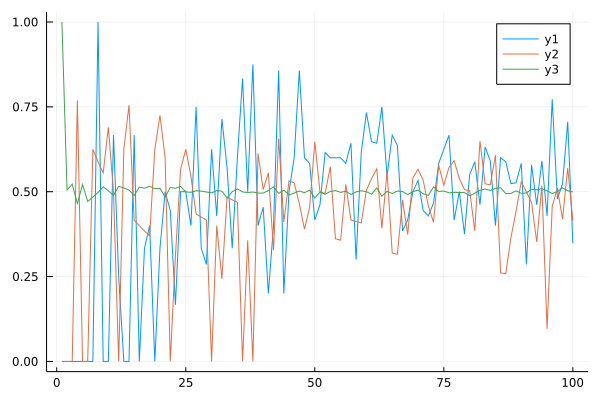

In [55]:
plot(temp1)
plot!(temp2)
plot!(temp3)

## Inference in Gaussian Models

If the joint distribution is Gaussian, we can perform exact inference analytically.

In [61]:
using Distributions

In [62]:
MvNormal

MvNormal

In [66]:
function infer(D::MvNormal, query, evidencevars, evidence)
    # A vector of integers specifies the query variables in the `query` argument
    # A vector of integers specifies the evidence variables in the `evidencevars` argument
    # The values of the evidence variables are contained in the vector `evidence`
    μ, Σ = D.μ, D.Σ.mat
    b, μa, μb = evidence, μ[query], μ[evidencevars]
    A = Σ[query, query]
    B = Σ[evidencevars, evidencevars]
    C = Σ[query, evidencevars]
    μ = μ[query] + C * (B\(b-μb))
    Σ = A - C * (B \ C')
    return MvNormal(μ, Σ)
end

infer (generic function with 6 methods)

In [58]:
A = rand(5,5)

5×5 Matrix{Float64}:
 0.227159   0.764097   0.466987  0.346521  0.611759
 0.438928   0.0530954  0.166553  0.350378  0.203684
 0.585236   0.520071   0.184206  0.886542  0.0302573
 0.0152078  0.989532   0.232248  0.510437  0.107842
 0.641432   0.46879    0.353757  0.520356  0.640759

In [59]:
A[[1,3,5], [1,3,5]]

3×3 Matrix{Float64}:
 0.227159  0.466987  0.611759
 0.585236  0.184206  0.0302573
 0.641432  0.353757  0.640759

In [67]:
# An example (Example 3.7 in the book)
D = MvNormal([0.0,1.0], [3.0 1.0;1.0 2.0])

FullNormal(
dim: 2
μ: [0.0, 1.0]
Σ: [3.0 1.0; 1.0 2.0]
)


In [68]:
infer(D, [1], [2], [2.0]) # The conditional distribution for x1 given x2 = 2

FullNormal(
dim: 1
μ: [0.5]
Σ: [2.5]
)
